In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#to use the seaborn colors in other plots:
from matplotlib.colors import ListedColormap
sns_cmap = ListedColormap(sns.color_palette('deep'))
sns_blue_orange = ListedColormap(sns.color_palette('deep')[:2])
sns_blue = sns.color_palette('deep')[0]
sns_orange = sns.color_palette('deep')[1]

In [2]:
df = pd.read_excel('gestationalDiabetes.xlsx', index_col = 0)
GDB = 'Class Label(GDM /Non GDM)'

# Introduction

According to the CDC, gestational diabetes (GDM) occurs in an estimated 2% to 10% of pregnancies. A diagnosis of GDM raises the risk of poor outcomes for both mother and child. Gestational diabetes is of personal interest to me because my wife had gestational diabetes when she was pregnant with our daughter. Thankfully, we were able to keep it controlled through dietary interventions alone, and our daughter was born without complications.

Because effective interventions exist, diagnosing GDM during pregnancy is of great benefit to mother and child. The standard diagnostic tool is the Oral Glucose Tolerance test, which is administered during pregnancy. I was curious about the prospect of using machine learning to predict a GDM diagnosis. How well could such a model perform?

After a bit of research, I found that [researchers in India](https://www.techscience.com/cmc/v69n3/44131/html) explored this question already. They collected data on pregnancies and trained a model that detects GDM with high accuracy. They made this [data](https://www.kaggle.com/datasets/sumathisanthosh/gestational-diabetes-mellitus-gdm-data-set) publicly available.

The data collected by the researchers includes standard health metrics collected during an annual physical: blood pressure, age, BMI, etc. But the data also includes more specific features, like the presence of Polycystic Ovary Syndrome (PCOS), as well as details about the pregnancy and previous pregnancies. I wanted to see how well we could predict GDM using only measurements that are typically taken during an annual physical. Such a tool could perhaps be used by general practictioners to flag women at risk of GDM.

As a disclaimer, I am not a physician and the results of this analysis are not a diagnostic tool or medical advice!

# The Data

The dataset consists of a presumably non-representative sample of pregnancies, with just over a third of the pregnancies featuring a GDM diagnosis.

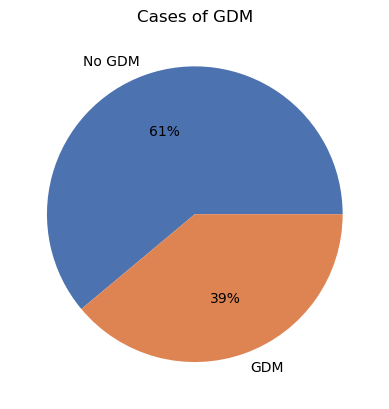

In [91]:
by_gd = df.groupby(by = GDB)

by_gd.apply(lambda x: len(x)/len(df)).plot(kind = 'pie', 
                                           labels = ['No GDM', 'GDM'],
                                           colormap = sns_blue_orange,
                                           autopct= lambda x: '{:.0f}%'.format(x),)
plt.title('Cases of GDM')
plt.ylabel('')
plt.show()

Compared to controls, women with GDM are older, have higher BMI, higher blood pressure measurements, and lower HDL cholesterol. These differences are substantial, as the boxplots below indicate. 

In [30]:
quantitative = ['Age','HDL','BMI','Sys BP','Dia BP']

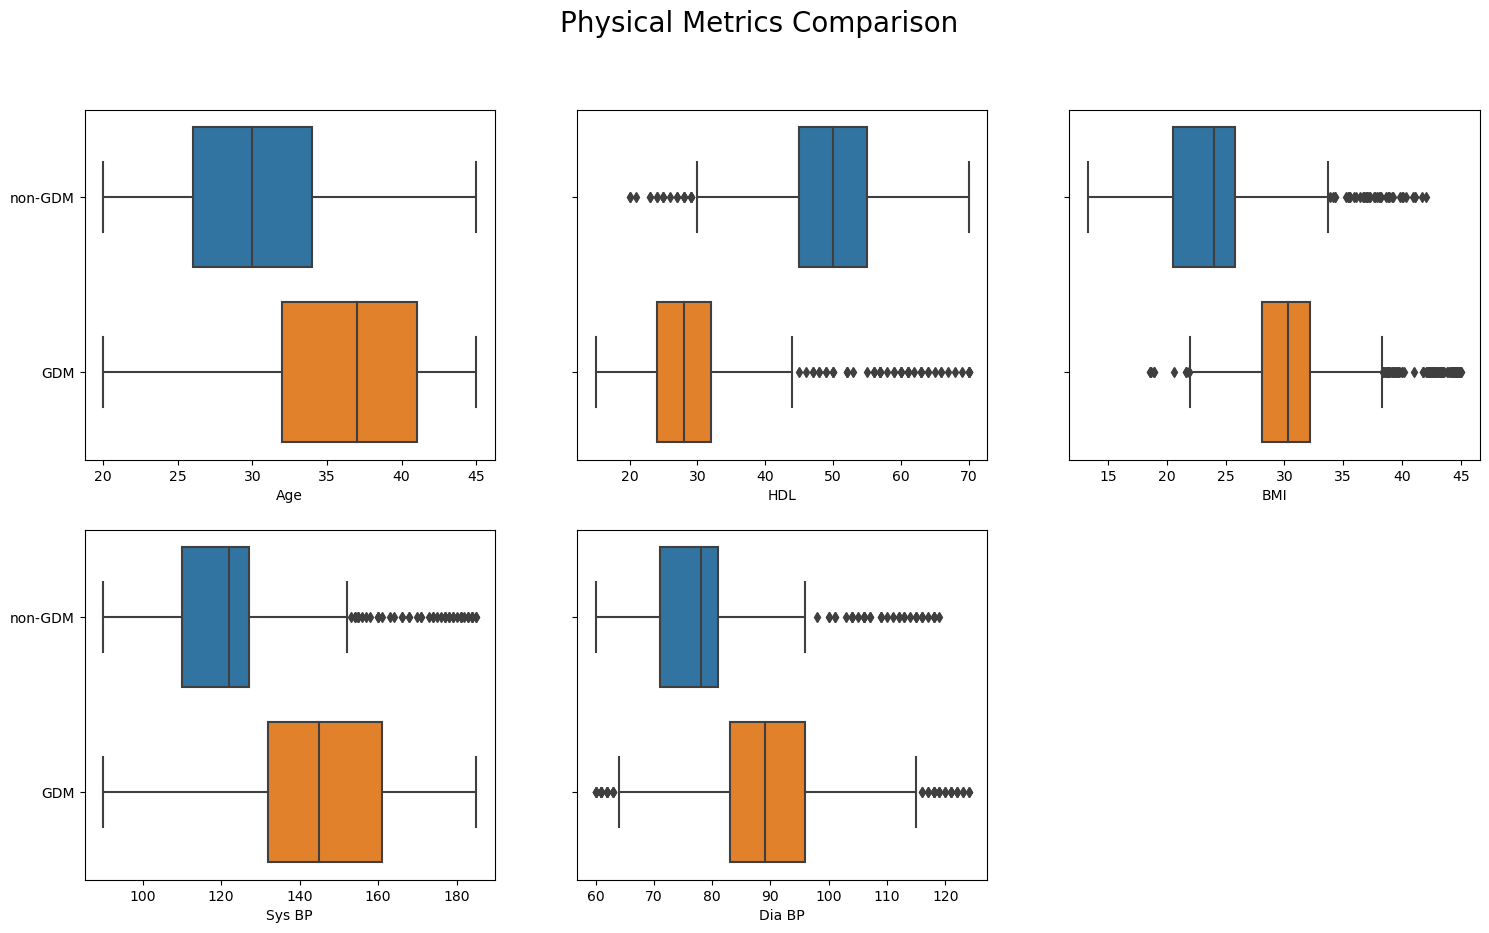

In [31]:
fig, axes = plt.subplots(2,3, figsize = (18,10), sharey = True)
fig.suptitle('Physical Metrics Comparison', fontsize = 20)
axes[-1,-1].axis('off')

for i in range(5):
    ax = axes[(i//3),(0+i)%3]
    sns.boxplot(ax = ax,
                data = df, 
                x = quantitative[i], 
                y = GDB,
                orient = 'h',
                palette = 'tab10'
               )
    ax.set_ylabel('')
    ax.set_yticks([0,1],['non-GDM','GDM'])
    

In addition to these quantitative measures, the dataset also includes a prediabetes category. For this dataset, prediabetes turns out to be highly specific (almost always indicates GDM) and somewhat sensitive (usually present with GDM).

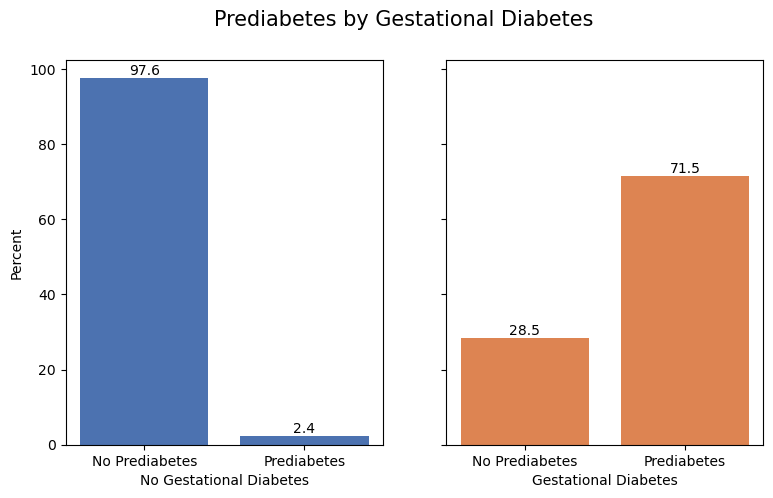

In [61]:
#create figure
fig, axes = plt.subplots(1,2, figsize = (9,5), sharey = True)
fig.suptitle('Prediabetes by Gestational Diabetes', fontsize = 15)
gd_df = df[df[GDB] == 1]
gd_pre = 100*gd_df.groupby(['Prediabetes']).apply(len)/len(gd_df)
ngd_df = df[df[GDB] == 0]
ngd_pre = 100*ngd_df.groupby(['Prediabetes']).apply(len)/len(ngd_df)

#first graph
bars0 = axes[0].bar(x = [0,1], 
            height = ngd_pre, 
            tick_label = ['No Prediabetes','Prediabetes'],
            color = sns_blue)
axes[0].bar_label(bars0, fmt = '%.1f')
axes[0].set_ylabel('Percent')

#second graph
axes[0].set_xlabel('No Gestational Diabetes')
bars1 = axes[1].bar(x = [0,1], 
            height = gd_pre, 
            tick_label = ['No Prediabetes','Prediabetes'], 
            color = sns_orange)
axes[1].bar_label(bars1, fmt = '%.1f')
axes[1].set_xlabel('Gestational Diabetes')
plt.show()

Prediabetes can be diagnosed by measuring fasting glucose, and also by Hemoglobin A1C, both of which are typically measured during an annual physical.

# Machine Learning Model

Using the features of age, body mass index, HDL cholesterol, systolic blood pressure, diastolic blood pressure, and presence of prediabetes, I trained several different machine learning models on the resulting data set. Before doing so, I imputed missing values for BMI and HDL based on the mean, and used linear regression to impute values for systolic blood pressure based on diastolic blood pressure.

The models I tried were logistic regression, k-nearest neighbors, support vector machines, and random forests. The random forest model substantially outperformed the other models, with 97\% accuracy. Precision and recall on GDM diagnosis were 0.95 and 0.98 respectively.

Random forest models can be used to produce a probability, rather than exact prediction. This can be interpreted as an individual's risk of gestational diabetes. Using this model and interpretation, I built a [simple webapp](https://gestational-diabetes-calculator.onrender.com/). The code for the original analysis and the webapp are [here](https://github.com/philwillnyc/GestationalDiabetes). The user inputs age, blood pressure measurements, HDL cholesterol, height and weight (used to compute BMI), fasting glucose and Hemoglobin A1C (used to determine prediabetes), and the app returns a percentage risk for gestational diabetes. Again I feel compelled to give the disclaimer that this is just a fun project and should not be used for actual diagnostic purposes!

# Conclusion

Gestational diabetes is a serious condition that affects a surprisingly large proportion of pregnancies. Several of the most commonly measured physical metrics are strongly predictive of gestational diabetes. I'm interested in learning more about how this could be leveraged in a healthcare setting. The logical next step would be to see how well our model performs on real world data.
